# Supervised Learning and K Nearest Neighbors Exercises

## Introduction

We will be using customer churn data from the telecom industry for this week's exercises. The data file is called 
`Orange_Telecom_Churn_Data.csv`. We will load this data together, do some preprocessing, and use K-nearest neighbors to predict customer churn based on account characteristics.

In [21]:
from __future__ import print_function
import os
data_path = ['data']

## Question 1

* Begin by importing the data. Examine the columns and data.
* Notice that the data contains a state, area code, and phone number. Do you think these are good features to use when building a machine learning model? Why or why not? 

We will not be using them, so they can be dropped from the data.

In [22]:
import pandas as pd

# Import the data using the file path
filepath = os.sep.join(data_path + ['Orange_Telecom_Churn_Data.csv'])
data = pd.read_csv(filepath)

In [23]:
data.head(1)

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False


In [24]:
# Remove extraneous columns
data.drop(['state', 'area_code', 'phone_number'], axis=1, inplace=True)

In [25]:
data.columns

Index(['account_length', 'intl_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls', 'churned'],
      dtype='object')

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_length                 5000 non-null   int64  
 1   intl_plan                      5000 non-null   object 
 2   voice_mail_plan                5000 non-null   object 
 3   number_vmail_messages          5000 non-null   int64  
 4   total_day_minutes              5000 non-null   float64
 5   total_day_calls                5000 non-null   int64  
 6   total_day_charge               5000 non-null   float64
 7   total_eve_minutes              5000 non-null   float64
 8   total_eve_calls                5000 non-null   int64  
 9   total_eve_charge               5000 non-null   float64
 10  total_night_minutes            5000 non-null   float64
 11  total_night_calls              5000 non-null   int64  
 12  total_night_charge             5000 non-null   f

## Question 2

* Notice that some of the columns are categorical data and some are floats. These features will need to be numerically encoded using one of the methods from the lecture.
* Finally, remember from the lecture that K-nearest neighbors requires scaled data. Scale the data using one of the scaling methods discussed in the lecture.

In [27]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

for col in ['intl_plan', 'voice_mail_plan', 'churned']:
    data[col] = lb.fit_transform(data[col]) 

# encoder = LabelEncoder()    
# for col in [cols_to_encode]:
#    data[col] = encoder.fit_transform(data[col])

In [28]:
# Mute the sklearn warning
import warnings
warnings.filterwarnings('ignore', module='sklearn')

from sklearn.preprocessing import MinMaxScaler

msc = MinMaxScaler()

data = pd.DataFrame(msc.fit_transform(data),  # this is an np.array, not a dataframe.
                    columns=data.columns)

In [29]:
data.head()

,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,0.524793,0.0,1.0,0.480769,0.754196,0.666667,0.754183,0.542755,0.582353,0.542866,0.619494,0.520000,0.619584,0.500,0.15,0.500000,0.111111,0.0
1,0.438017,0.0,1.0,0.500000,0.459744,0.745455,0.459672,0.537531,0.605882,0.537690,0.644051,0.588571,0.644344,0.685,0.15,0.685185,0.111111,0.0
2,0.561983,0.0,0.0,0.000000,0.692461,0.690909,0.692436,0.333242,0.647059,0.333225,0.411646,0.594286,0.411930,0.610,0.25,0.609259,0.000000,0.0
3,0.342975,1.0,0.0,0.000000,0.851778,0.430303,0.851740,0.170195,0.517647,0.170171,0.498481,0.508571,0.498593,0.330,0.35,0.329630,0.222222,0.0
4,0.305785,1.0,0.0,0.000000,0.474253,0.684848,0.474230,0.407754,0.717647,0.407959,0.473165,0.691429,0.473270,0.505,0.15,0.505556,0.333333,0.0


In [30]:
data.voice_mail_plan.value_counts()

0.0    3677
1.0    1323
Name: voice_mail_plan, dtype: int64

## Question 3

* Separate the feature columns (everything except `churned`) from the label (`churned`). This will create two tables.
* Fit a K-nearest neighbors model with a value of `k=3` to this data and predict the outcome on the same data.

In [31]:
# Get a list of all the columns that don't contain the label
x_cols = [x for x in data.columns if x != 'churned']
# [x for x in data.columns if x =! 'churned']
# Split the data into two dataframes
X_data = data[x_cols]
y_data = data['churned']

# # alternatively:
# X_data = data.copy()
# y_data = X_data.pop('churned')

In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

knn = knn.fit(X_data, y_data)

y_pred = knn.predict(X_data)

## Question 4

Ways to measure error haven't been discussed in class yet, but accuracy is an easy one to understand--it is simply the percent of labels that were correctly predicted (either true or false). 

* Write a function to calculate accuracy using the actual and predicted labels.
* Using the function, calculate the accuracy of this K-nearest neighbors model on the data.

In [33]:
# Function to calculate the % of values that were correctly predicted

def accuracy(real, predict):
    return sum(y_data == y_pred) / float(real.shape[0])
# def accuracy(actual, predicted):
#    return sum(y_data == y_pred) / float(actual.shape[0])

In [34]:
print(accuracy(y_data, y_pred))

0.9422


## Question 5

* Fit the K-nearest neighbors model again with `n_neighbors=3` but this time use distance for the weights. Calculate the accuracy using the function you created above. 
* Fit another K-nearest neighbors model. This time use uniform weights but set the power parameter for the Minkowski distance metric to be 1 (`p=1`) i.e. Manhattan Distance.

When weighted distances are used for part 1 of this question, a value of 1.0 should be returned for the accuracy. Why do you think this is? *Hint:* we are predicting on the data and with KNN the model *is* the data. We will learn how to avoid this pitfall in the next lecture.

In [43]:
#Student writes code here
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors = 3 , p=1)
knn.fit(X_data, y_data)
y_pred = knn.predict(X_data)

In [44]:
def accuracy(actual, predicted):
    return sum(y_data == y_pred) / float(actual.shape[0])
accuracy(y_data, y_pred)

0.9456

## Question 6

* Fit a K-nearest neighbors model using values of `k` (`n_neighbors`) ranging from 1 to 20. Use uniform weights (the default). The coefficient for the Minkowski distance (`p`) can be set to either 1 or 2--just be consistent. Store the accuracy and the value of `k` used from each of these fits in a list or dictionary.
* Plot (or view the table of) the `accuracy` vs `k`. What do you notice happens when `k=1`? Why do you think this is? *Hint:* it's for the same reason discussed above.

In [ ]:
#Student writes code here

In [46]:
accuracy = list()
k_range = range(1,21)

    
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k , p =2 ) # euclidean_distance 
    knn.fit(X_data, y_data)
    y_pred = knn.predict(X_data)
    score = sum(y_pred) / float(y_data.shape[0])
    accuracy.append(score)

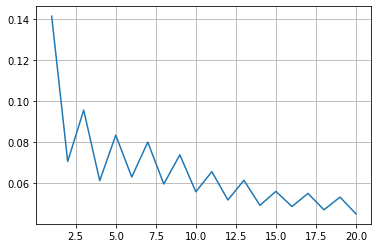

In [50]:
import matplotlib.pyplot as plt 
%matplotlib inline 

plt.plot(k_range, accuracy);
plt.grid()